In [1]:
import os
from functools import partial

import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
from shapely.geometry import box
from shapely.ops import cascaded_union, transform
import rasterio
from rasterio import mask

import folium
import geojson
import requests
import json

from landsat_grabber import planetary_computer

## Download Sat data and create MNDWI mask

In [2]:
crs = 'epsg:4326'

satelite_to_use = 'sentinel'

# define a landsat data grabber object
sat = planetary_computer(satelite_to_use)

## time to get some data

# first define time range and cloud cover threshold
time_range = "2019-03-21/2020-03-21"
cloud_cover = 10

# use geojson.io to get coordinates from a polygon for testing
area_of_interest = geojson.load(open("aoi.geojson"))


# finally import landsat data
sat.get_aoi_data(area_of_interest, time_range, cloud_cover=cloud_cover, resolution=10)

# show the data
sat.data


/home/cmclean/.local/lib/python3.8/site-packages/stackstac/accumulate_metadata.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  props_arr = np.squeeze(np.array(props))


<xarray.DataArray 'stackstac-cfd14e4146d684ecb2ecdb4e701b7d20' (time: 70, band: 5, y: 374, x: 471)>
dask.array<fetch_raster_window, shape=(70, 5, 374, 471), dtype=float64, chunksize=(1, 1, 374, 471), chunktype=numpy.ndarray>
Coordinates:
  * time                                     (time) datetime64[ns] 2019-03-25...
    id                                       (time) <U54 'S2B_MSIL2A_20190325...
  * band                                     (band) <U6 'blue' ... 'swir16'
  * x                                        (x) float64 -1.172e+07 ... -1.17...
  * y                                        (y) float64 4.832e+06 ... 4.829e+06
    s2:high_proba_clouds_percentage          (time) float64 5.232 ... 3.361
    platform                                 (time) object None ... 'Sentinel...
    s2:vegetation_percentage                 (time) float64 1.017 3.85 ... 10.59
    s2:product_uri                           (time) <U65 'S2B_MSIL2A_20190325...
    eo:cloud_cover                           (time) float64 7.675 ... 9.249
    s2:cloud_shadow_percentage               (time) float64 1.099 ... 1.71
    s2:thin_cirrus_percentage                (time) float64 0.3197 0.0 ... 0.0
    s2:mgrs_tile                             (time) <U5 '13TDE' ... '13SDD'
    instruments                              <U3 'msi'
    s2:datastrip_id                          (time) <U64 'S2B_OPER_MSI_L2A_DS...
    sat:relative_orbit                       (time) object None 98 141 ... 98 98
    s2:processing_baseline                   <U5 '02.12'
    s2:snow_ice_percentage                   (time) float64 1.066 ... 17.26
    sat:orbit_state                          <U10 'descending'
    s2:dark_features_percentage              (time) float64 1.916 ... 1.378
    constellation                            <U10 'Sentinel 2'
    s2:granule_id                            (time) <U62 'S2B_OPER_MSI_L2A_TL...
    proj:epsg                                int64 32613
    s2:nodata_pixel_percentage               (time) float64 75.04 ... 53.87
    s2:product_type                          <U7 'S2MSI2A'
    s2:generation_time                       (time) <U24 '2020-10-07T10:42:23...
    s2:not_vegetated_percentage              (time) float64 80.2 45.31 ... 42.76
    s2:degraded_msi_data_percentage          float64 0.0
    s2:mean_solar_azimuth                    (time) float64 151.2 ... 151.9
    s2:saturated_defective_pixel_percentage  float64 0.0
    s2:reflectance_conversion_factor         (time) object None ... 1.0136626...
    s2:datatake_id                           (time) object None ... 'GS2A_202...
    s2:datatake_type                         <U8 'INS-NOBS'
    s2:water_percentage                      (time) float64 2.519 ... 0.3543
    s2:unclassified_percentage               (time) float64 4.506 18.44 ... 16.7
    s2:medium_proba_clouds_percentage        (time) float64 2.123 ... 5.888
    s2:mean_solar_zenith                     (time) float64 41.87 41.06 ... 45.1
    proj:shape                               (band) object None ... [5490, 5490]
    gsd                                      (band) object None None None 10 20
    title                                    (band) <U26 'Band 2 - Blue - 10m...
    common_name                              (band) <U6 'blue' ... 'swir16'
    center_wavelength                        (band) float64 0.49 0.56 ... 1.61
    full_width_half_max                      (band) float64 0.098 ... 0.143
    epsg                                     int64 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-11715810, 4828590, -11711100,...
    crs:         epsg:3857
    transform:   | 10.00, 0.00,-11715810.00|\n| 0.00,-10.00, 4832330.00|\n| 0...
    resolution:  10

/home/cmclean/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/cmclean/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


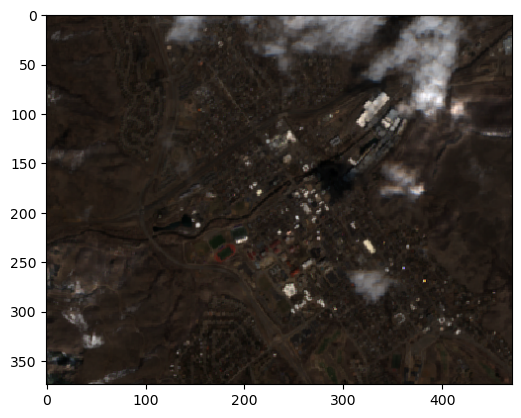

In [3]:
num = 0

rgb = sat.make_composite_rgb(num)
h, w, _ = rgb.shape

# transform crs
crs_project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:3857'), # source coordinate system
    pyproj.Proj(init='epsg:4326') # destination coordinate system
)

bbox = sat.data[0].spec.bounds

# read bounds from dataset and transform to wgs84
osm_poly = transform(crs_project, box(bbox[0], bbox[1], bbox[2], bbox[3]))

plt.imshow(rgb)
plt.show()

## Import building footprints

In [4]:
path = 'automated-building-detection/abd-predictions/buildings-clean.geojson'

gdf = gpd.read_file(path)

gdf_proj = gdf.to_crs(crs)


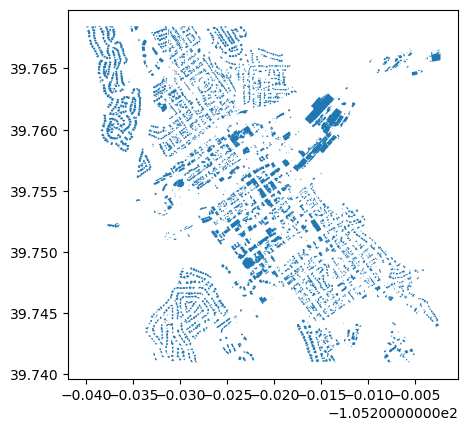

In [5]:
gdf_proj.plot()
plt.show()

## Download Flood Hazard Map

download the flood map based on bbox from fema national flood hazard database

In [6]:

url = 'https://hazards.fema.gov/gis/nfhl/rest/services/public/NFHLWMS/MapServer/28/query?where=&text=&objectIds=&time=&geometry={0}%2C+{1}%2C+{2}%2C+{3}&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelContains&distance=&units=esriSRUnit_Foot&relationParam=&outFields=&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&havingClause=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&featureEncoding=esriDefault&f=geojson'
url = url.format(*tuple(osm_poly.bounds))

val = requests.get(url)
j = json.dumps(val.json())


In [7]:
hazard = gpd.read_file(j)
hazard.to_crs(crs='epsg:3857', inplace=True)
boundary = cascaded_union(list(hazard['geometry']))

hazard.head()

<ipython-input-7-501b4a6fd58b>:3: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  boundary = cascaded_union(list(hazard['geometry']))


FLD_AR_ID                                           geometry
0  08059C_2864  POLYGON ((-11713040.689 4830781.315, -11713036...
1  08059C_2865  POLYGON ((-11713858.091 4830249.227, -11713848...
2  08059C_2244  POLYGON ((-11714504.737 4830034.984, -11714520...
3  08059C_2246  POLYGON ((-11714116.205 4830194.972, -11714126...
4  08059C_1128  POLYGON ((-11712898.804 4830849.498, -11712898...

In [12]:
hazard.plot()
plt.axis('off')
plt.savefig('out.png',bbox_inches='tight')

In [13]:
import cv2
import numpy as np


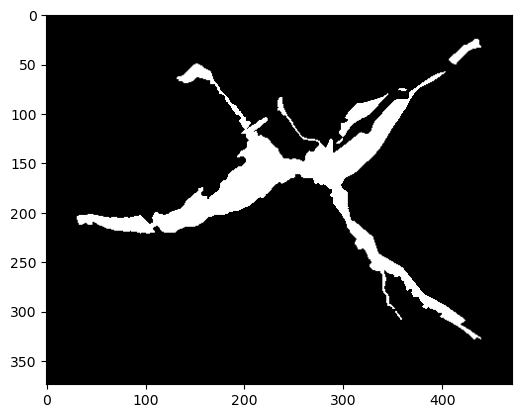

In [32]:
mask = cv2.imread('out.png', cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (w, h))
mask = np.bitwise_not(mask)
mask = cv2.threshold(mask,50,1,cv2.THRESH_BINARY)[1]

plt.imshow(mask, cmap='gray')
plt.show()


In [33]:
np.save('masks/1.npy', mask)

In [11]:
s = sat.data_stack(0)
np.save('bands.npy', s)

## Extract Flood Impacted buildings

Until this point, we set the stage for actual task. Basically, the building footprints that intersects the Multipolygon (one we created from MNDWI) are effected building and those that are not are not-effected buildings!

In [ ]:
effected = gdf_proj[gdf_proj['geometry'].intersects(boundary)]
# change coordinate system for plotting
effected.to_crs(crs=crs, inplace=True)
effected.head()

In [ ]:
not_effected = gdf_proj[~gdf_proj['geometry'].intersects(boundary)]
# change coordinate system for plotting
not_effected.to_crs(crs=crs, inplace=True)
not_effected.head()

In [ ]:
# quick sanity check
gdf_proj.shape[0] == (effected.shape[0] + not_effected.shape[0])

It's time for plotting. We will use Folium library for displaying our results. Of course, it requires a bit of massaging before we get to the plotting

### Plotting

In [ ]:
# bbox centroid serves as the center point for the folium map
bbox_centroid = list((osm_poly.centroid).coords[:][0])
bbox_centroid = [bbox_centroid[-1], bbox_centroid[0]]
bbox_centroid

In [ ]:
# extracts bounds for image overlay
lon_min, lat_min, lon_max, lat_max = osm_poly.bounds

In [ ]:
style0 = {'fillColor': '#00FFFFFF', 'color': 'black'}
style1 = {'fillColor': '#228B22', 'color': 'red'}
style2 = {'fillColor': '##B0FFE8', 'color': 'green'}
style3 = {'fillColor': '#00FFFFFF', 'color': 'blue'}

In [ ]:
# init folium map
m = folium.Map(bbox_centroid, zoom_start=15)

# add all buildings
folium.GeoJson(gdf_proj.to_json(), style_function=lambda x:style0).add_to(m)


# # add effected buildings
folium.GeoJson(effected.to_json(), style_function=lambda x:style1).add_to(m)

# # add not_effected buildings
folium.GeoJson(not_effected.to_json(), style_function=lambda x:style2).add_to(m)

folium.GeoJson(hazard.to_json(), style_function=lambda x:style3).add_to(m)

# add raster png quicklook
folium.raster_layers.ImageOverlay(image=rgb, bounds=[[lat_min, lon_min], [lat_max, lon_max]], opacity=0.85).add_to(m)

In [ ]:
folium.LayerControl().add_to(m)
m

As we can see the buildings impacted by flooding in red and those that are not impacted are in blue.

It should be noted that success of the analysis depends on the availability of the data in OSM!!

In [ ]:
m.save("out.html")